# 6.1 Logistic Regression
In this notebook, we will train logistic regression and try four feature selection methods. We will further perform hyperparameter tuning to improve model performance. 

Logistic regression is one basic model for classification problem. It sometimes exhibits strong performance despite its relatively simple algorithm.

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from Utils import plotMetricsGraphComparison
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, feature_selection_using_rfecv_on_f1score

## Import Train and Test Datasets

In [3]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
Y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
Y_test = pd.read_csv("Data/y_test.csv")

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [4]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Classification Model": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [5]:
train_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Baseline Model before Feature Engineering

In [6]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [7]:
lr_basic = LogisticRegression(max_iter=10000, random_state=47).fit(X_train_basic, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_basic = lr_basic.predict(X_train_basic)
Y_test_pred_basic = lr_basic.predict(X_test_basic)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.788495488426834
Precision 	: 0.7856657278819074
Recall 		: 0.7934484111416241
F1 Score 	: 0.7895378909871663

**Test Set Metrics**
Accuracy 	: 0.8136007827788649
Precision 	: 0.5600303951367781
Recall 		: 0.43816884661117717
F1 Score 	: 0.4916611074049366


## Baseline Model after Feature Engineering

In [8]:
# Train Logistic Regression model on the training data without feature selection
lr = LogisticRegression(max_iter=10000, random_state=47).fit(X_train, Y_train.values.ravel())  # Use values.ravel() to flatten y_train

# Make predictions on the training and testing data
Y_train_pred_engineered = lr.predict(X_train)
Y_test_pred_engineered = lr.predict(X_test)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_engineered, Y_test, Y_test_pred_engineered, "After Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7913397410749313
Precision 	: 0.794196295929484
Recall 		: 0.7864848960376618
F1 Score 	: 0.7903217858374809

**Test Set Metrics**
Accuracy 	: 0.8018590998043053
Precision 	: 0.5192546583850932
Recall 		: 0.49702734839476814
F1 Score 	: 0.5078979343863912


From the results, we can see a general improvement in model performance on the training set after feature engineering. Therefore, we would use the engineered dataset in feature selection.

## Feature Selection for LR

We are applying multiple techniques for LR feature selection:
1. Eliminate the Features with zero permutation_importance
2. Forward feature selection
3. Backward Feature Elimination
4. Recursive Feature Elimination
5. Univariate Feature Selectionion

### Eliminate the Features with permutation_importance=0

This step aims to remove features that do not contribute to the model's ability to capture meaningful patterns in the data.

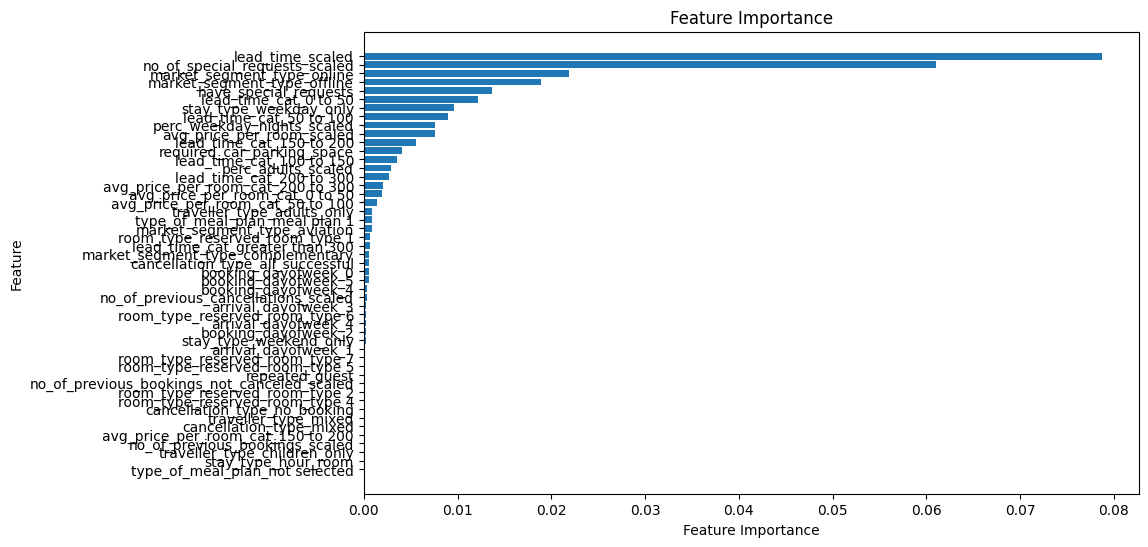

In [9]:
feature_importances, feature_names = compute_permutation_importance(lr, X_train, Y_train)

# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [10]:
selected_columns = feature_names

In [11]:
num_columns = X_train[selected_columns].shape[1]
print("Number of selected features:", num_columns)

Number of selected features: 49


### Fit the model again with the newly selected features

In [12]:
lr_selected = LogisticRegression(max_iter=10000, random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_selected = lr_selected.predict(X_train[selected_columns])
Y_test_pred_selected = lr_selected.predict(X_test[selected_columns])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Eliminate 0 Permutation Impt", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7958513142408787
Precision 	: 0.7966368374471433
Recall 		: 0.7945272655943507
F1 Score 	: 0.7955806530812669

**Test Set Metrics**
Accuracy 	: 0.8034491193737769
Precision 	: 0.5228798047589994
Recall 		: 0.509512485136742
F1 Score 	: 0.5161096055404999


This step allows us to reduce the dimensionality of the feature space, enhancing computational efficiency and potentially mitigating overfitting concerns, while maintaining model performance.

Next, we try to perform a few feature selection methods to choose the best method that would give us the best model performance.

### 1. Forward selection using SequentialFeatureSelector from sklearn

In [13]:
# Initialize a Logistic Regression classifier
lr = LogisticRegression(max_iter=10000, random_state=47)

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_forward = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_forward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_forward = X_train[selected_columns].columns[sfs_forward.get_support()]

# Train the final model using the selected features on the training set
lr_forward = lr.fit(X_train[selected_features_forward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_forward = lr_forward.predict(X_train[selected_features_forward])
Y_test_pred_forward = lr_forward.predict(X_test[selected_features_forward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_forward, Y_test, Y_test_pred_forward, "Forward Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.6748724990192232
Precision 	: 0.6342418310495407
Recall 		: 0.8262063554335033
F1 Score 	: 0.7176079734219268

**Test Set Metrics**
Accuracy 	: 0.6714774951076321
Precision 	: 0.30781010719754975
Recall 		: 0.4780023781212842
F1 Score 	: 0.37447601304145317


### 2. Backward elimination using SequentialFeatureSelector from sklearn

In [14]:
# Initialize a Logistic Regression classifier
lr = LogisticRegression(max_iter=10000, random_state=47)

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_backward = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='backward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_backward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_backward = X_train[selected_columns].columns[sfs_backward.get_support()]

# Train the final model using the selected features on the training set
lr_backward = lr.fit(X_train[selected_features_backward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_backward = lr_backward.predict(X_train[selected_features_backward])
Y_test_pred_backward = lr_backward.predict(X_test[selected_features_backward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_backward, Y_test, Y_test_pred_backward, "Backward Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7977147901137701
Precision 	: 0.7983292383292383
Recall 		: 0.7966849744998038
F1 Score 	: 0.7975062588974522

**Test Set Metrics**
Accuracy 	: 0.8016144814090019
Precision 	: 0.5186567164179104
Recall 		: 0.4958382877526754
F1 Score 	: 0.5069908814589666


### 3. Recursive Feature Elimination with cross validation

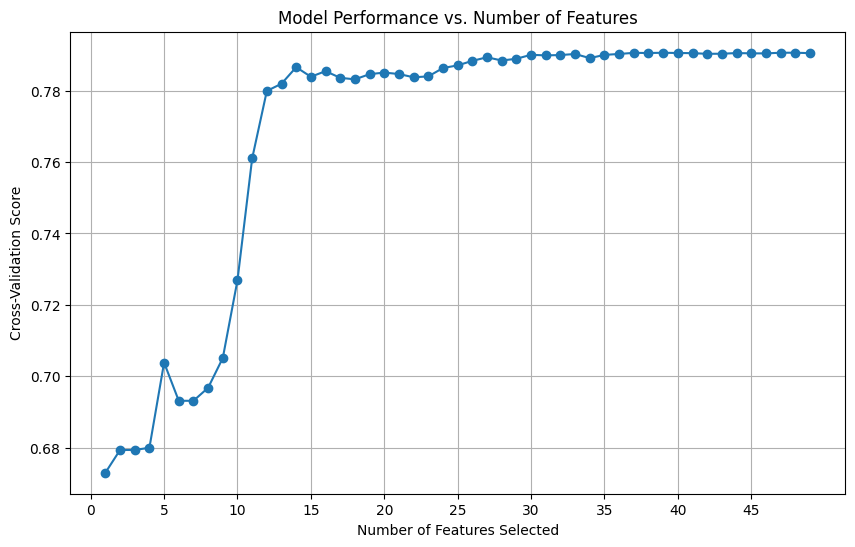

Optimal number of features based on F1 Score: 47


In [15]:
# Instantiate the Logistic Regression classifier
lr = LogisticRegression(max_iter=1000, random_state = 47)

# Call the forward_selection_with_metrics function
df_features = feature_selection_using_rfecv_on_f1score(lr, X_train[selected_columns], Y_train)

In [16]:
# Filter the selected features based on RFECV results
selected_features = df_features[df_features['selected']]['feature'][:40]

# Select only the selected features from the training and testing datasets
X_train_rfecv = X_train[selected_features]
X_test_rfecv = X_test[selected_features]

# Initialize the logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=47)

# Train the model using the selected features
lr.fit(X_train_rfecv, Y_train.values.ravel())

# Predict the target variable on the test set
Y_train_pred_rfecv = lr.predict(X_train_rfecv)
Y_test_pred_rfecv = lr.predict(X_test_rfecv)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_rfecv, Y_test, Y_test_pred_rfecv, "RFECV", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7135641428010985
Precision 	: 0.7281777218903909
Recall 		: 0.6815417810906238
F1 Score 	: 0.704088353006738

**Test Set Metrics**
Accuracy 	: 0.7248043052837574
Precision 	: 0.34080717488789236
Recall 		: 0.361474435196195
F1 Score 	: 0.3508366993652625


### 4. Univariate Feature Selection

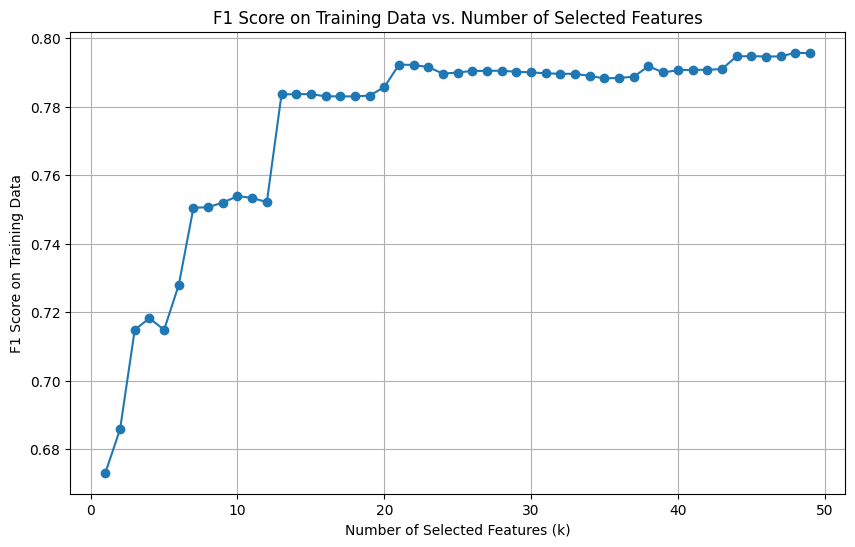

In [17]:
# Initialize LR classifier
lr = LogisticRegression(max_iter=1000, random_state=47)

# Initialize SelectKBest with f_classif scoring function
selector = SelectKBest(score_func=f_classif)

# Lists to store F1 scores and number of selected features
train_f1_scores = []
num_features_selected = []

# Iterate over different values of k
for k in range(1, X_train[selected_columns].shape[1] + 1):
    # Fit selector to training data with k features
    selector.set_params(k=k)
    X_train_selected = selector.fit_transform(X_train[selected_columns], Y_train.values.ravel())
    
    # Train LR classifier on selected features
    lr.fit(X_train_selected, Y_train.values.ravel())
    
    # Make predictions on the training data
    Y_train_pred = lr.predict(X_train_selected)
    
    # Calculate F1 score on the training data
    train_f1 = f1_score(Y_train, Y_train_pred)
    
    # Append F1 score and number of selected features to lists
    train_f1_scores.append(train_f1)
    num_features_selected.append(k)

# Plot F1 score vs. number of selected features
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, train_f1_scores, marker='o')
plt.title('F1 Score on Training Data vs. Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('F1 Score on Training Data')
plt.grid(True)
plt.show()

From the above graph, we can observe that while the optimal number of selected features (k) is 43, the difference between the F1 score when 24 features were selected and the optimal F1 score is relatively small. Hence, to prioritize reduction of the dimensionality of the feature space and model complexity, we choose 24 as the number of features to be selected and set k=24.

In [18]:
# Select the best features 
selector_24 = SelectKBest(f_classif, k= 24) 
selector_24.fit(X_train[selected_columns], Y_train.values.ravel()) 
X_train_selected_ufs = selector_24.transform(X_train[selected_columns]) 
X_test_selected_ufs = selector_24.transform(X_test[selected_columns]) 

In [19]:
features_ufs_indices = selector_24.get_support(indices=True)
features_ufs = X_train.columns[features_ufs_indices]
features_ufs

Index(['stay_type_hour_room', 'stay_type_weekday_only',
       'cancellation_type_all_cancelled', 'cancellation_type_no_booking',
       'lead_time_cat_0 to 50', 'lead_time_cat_greater than 300',
       'arrival_dayofweek_1', 'arrival_dayofweek_2', 'arrival_dayofweek_3',
       'arrival_dayofweek_6', 'booking_dayofweek_1', 'booking_dayofweek_2',
       'booking_dayofweek_3', 'booking_dayofweek_4', 'solo_traveller',
       'have_special_requests', 'arrival_isweekend',
       'num_of_customers_and_room_type_mismatch', 'perc_adults_scaled',
       'no_of_nights_scaled', 'perc_weekday_nights_scaled',
       'no_of_previous_bookings_scaled', 'previous_cancellation_rate_scaled',
       'type_of_meal_plan_meal plan 1'],
      dtype='object')

In [20]:
lr_ufs = LogisticRegression(max_iter=1000, random_state=47).fit(X_train_selected_ufs,Y_train.values.ravel())

# Make predictions on the testing data
Y_train_pred_selected_ufs = lr_ufs.predict(X_train_selected_ufs)
Y_test_pred_selected_ufs = lr_ufs.predict(X_test_selected_ufs)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_ufs, Y_test, Y_test_pred_selected_ufs, "Univariate Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7913887799136916
Precision 	: 0.796388667198723
Recall 		: 0.7829540996469203
F1 Score 	: 0.7896142433234421

**Test Set Metrics**
Accuracy 	: 0.8032045009784736
Precision 	: 0.5235940530058177
Recall 		: 0.4815695600475624
F1 Score 	: 0.5017033137194178


In [21]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.813601,0.560030,0.438169,0.491661
1,After Feature Engineering,0.801859,0.519255,0.497027,0.507898
2,Eliminate 0 Permutation Impt,0.803449,0.522880,0.509512,0.516110
3,Forward Feature Selection,0.671477,0.307810,0.478002,0.374476
4,Backward Feature Selection,0.801614,0.518657,0.495838,0.506991
5,RFECV,0.724804,0.340807,0.361474,0.350837
6,Univariate Feature Selection,0.803205,0.523594,0.481570,0.501703


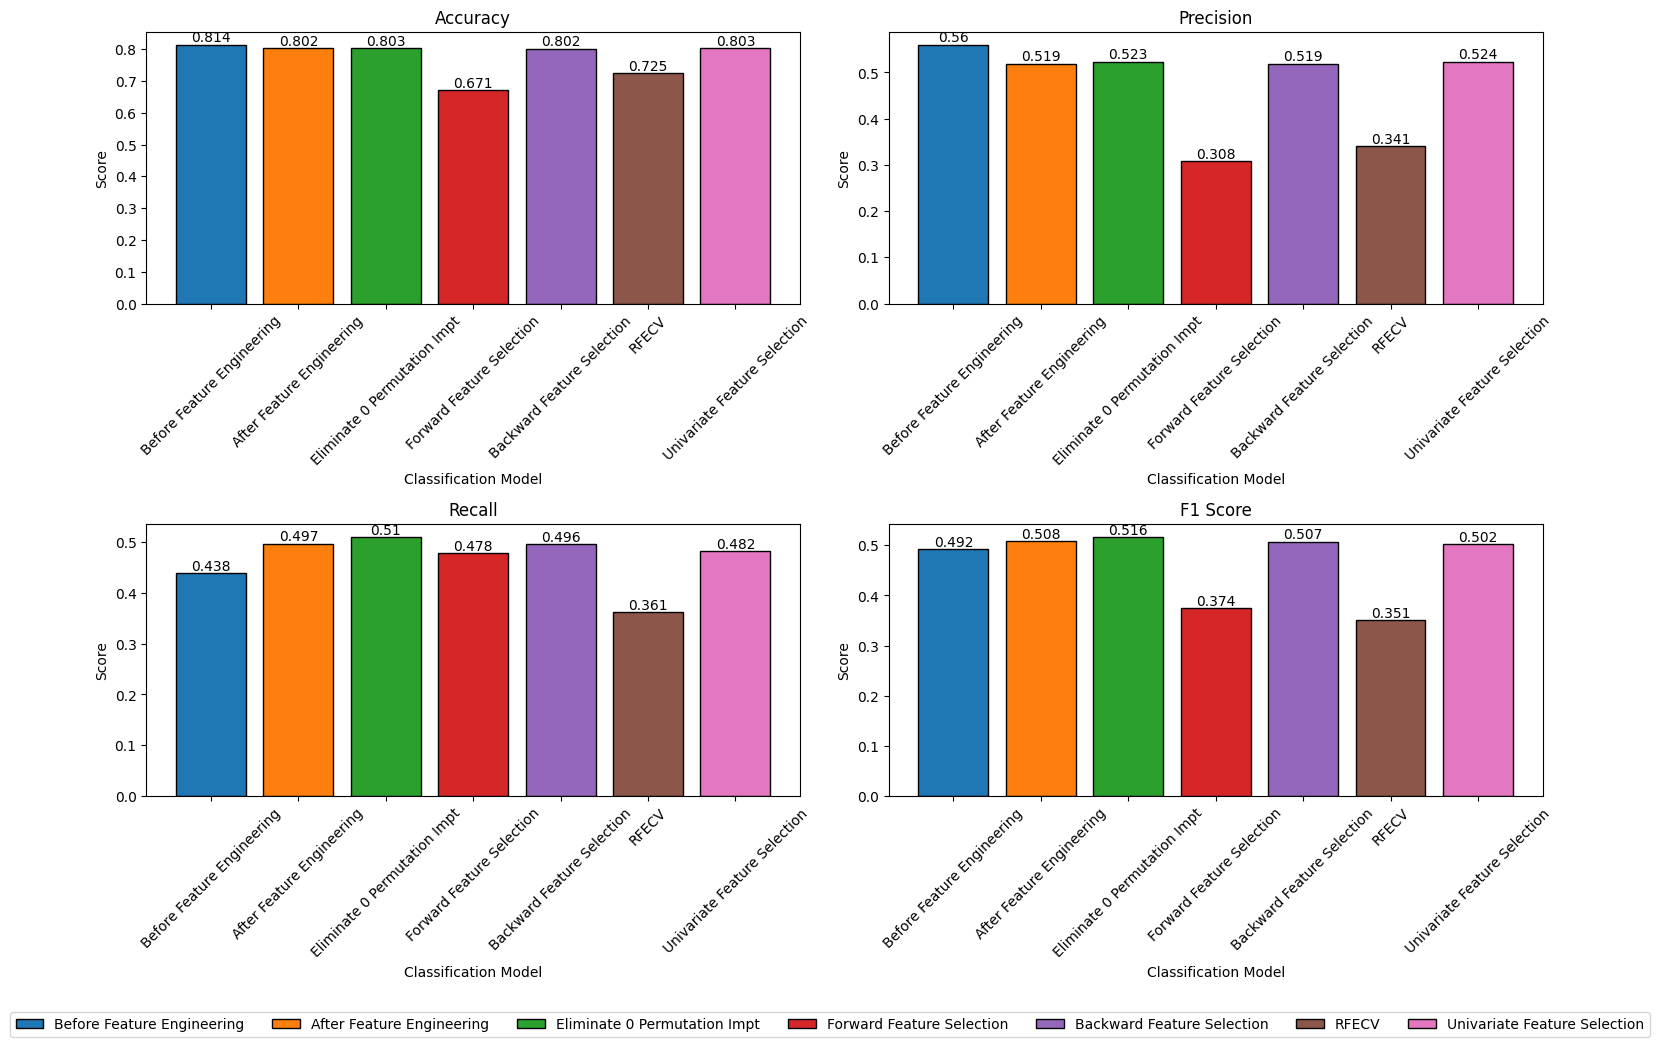

In [22]:
plotMetricsGraphComparison(test_metrics)

Comparing the results of the 4 feature selection methods, we observe that the backward elimination method improved the model performance the best. 

Let us now take a look at the details of the selected features.

In [23]:
num_features = len(selected_features_backward)
print("Number of selected features:", num_features)

Number of selected features: 25


In [24]:
print("Selected Features:", selected_features_backward)

Selected Features: Index(['type_of_meal_plan_not selected', 'room_type_reserved_room_type 4',
       'repeated_guest', 'arrival_dayofweek_1', 'booking_dayofweek_2',
       'arrival_dayofweek_4', 'arrival_dayofweek_3', 'booking_dayofweek_4',
       'booking_dayofweek_5', 'lead_time_cat_greater than 300',
       'room_type_reserved_room_type 1', 'market_segment_type_aviation',
       'avg_price_per_room_cat_50 to 100', 'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_200 to 300', 'lead_time_cat_200 to 300',
       'required_car_parking_space', 'lead_time_cat_150 to 200',
       'avg_price_per_room_scaled', 'lead_time_cat_50 to 100',
       'have_special_requests', 'market_segment_type_offline',
       'market_segment_type_online', 'no_of_special_requests_scaled',
       'lead_time_scaled'],
      dtype='object')


## Hyperparameter Tuning 
The main hyperparameters we may tune in logistic regression are: 
1. solver: the algorithm to use in the optimization problem
2. penalty: intends to reduce model generalization error, and is meant to disincentivize and regulate overfitting
3. regularization strength: works with the penalty to regulate overfitting (Smaller values specify stronger regularization and high value tells the model to give high weight to the training data.)

In [25]:
# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear', 'saga']  # Optimization algorithm
}


# Create a logistic regression model
logistic_model = LogisticRegression(max_iter=10000)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train[selected_features_backward], Y_train.values.ravel())

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


## Fit the model again with the tuned parameters

In [26]:
# Create a logistic regression model with the best hyperparameters
best_lr_model = LogisticRegression(max_iter=10000, C=0.1, penalty='l2', solver='liblinear', random_state = 47)

# Fit the logistic regression model to the training data
best_lr_model.fit(X_train[selected_features_backward], Y_train.values.ravel())

LogisticRegression(C=0.1, max_iter=10000, random_state=47, solver='liblinear')

In [27]:
# Make predictions on the testing data
Y_train_pred_tuned = best_lr_model.predict(X_train[selected_features_backward])
Y_test_pred_tuned = best_lr_model.predict(X_test[selected_features_backward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "After Hyperparameter Tuning", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7956551588858376
Precision 	: 0.7977872172280944
Recall 		: 0.7920753236563358
F1 Score 	: 0.7949210098922191

**Test Set Metrics**
Accuracy 	: 0.8025929549902152
Precision 	: 0.5215736040609137
Recall 		: 0.4887039239001189
F1 Score 	: 0.5046040515653776


In [28]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.813601,0.560030,0.438169,0.491661
1,After Feature Engineering,0.801859,0.519255,0.497027,0.507898
2,Eliminate 0 Permutation Impt,0.803449,0.522880,0.509512,0.516110
3,Forward Feature Selection,0.671477,0.307810,0.478002,0.374476
4,Backward Feature Selection,0.801614,0.518657,0.495838,0.506991
5,RFECV,0.724804,0.340807,0.361474,0.350837
6,Univariate Feature Selection,0.803205,0.523594,0.481570,0.501703
7,After Hyperparameter Tuning,0.802593,0.521574,0.488704,0.504604


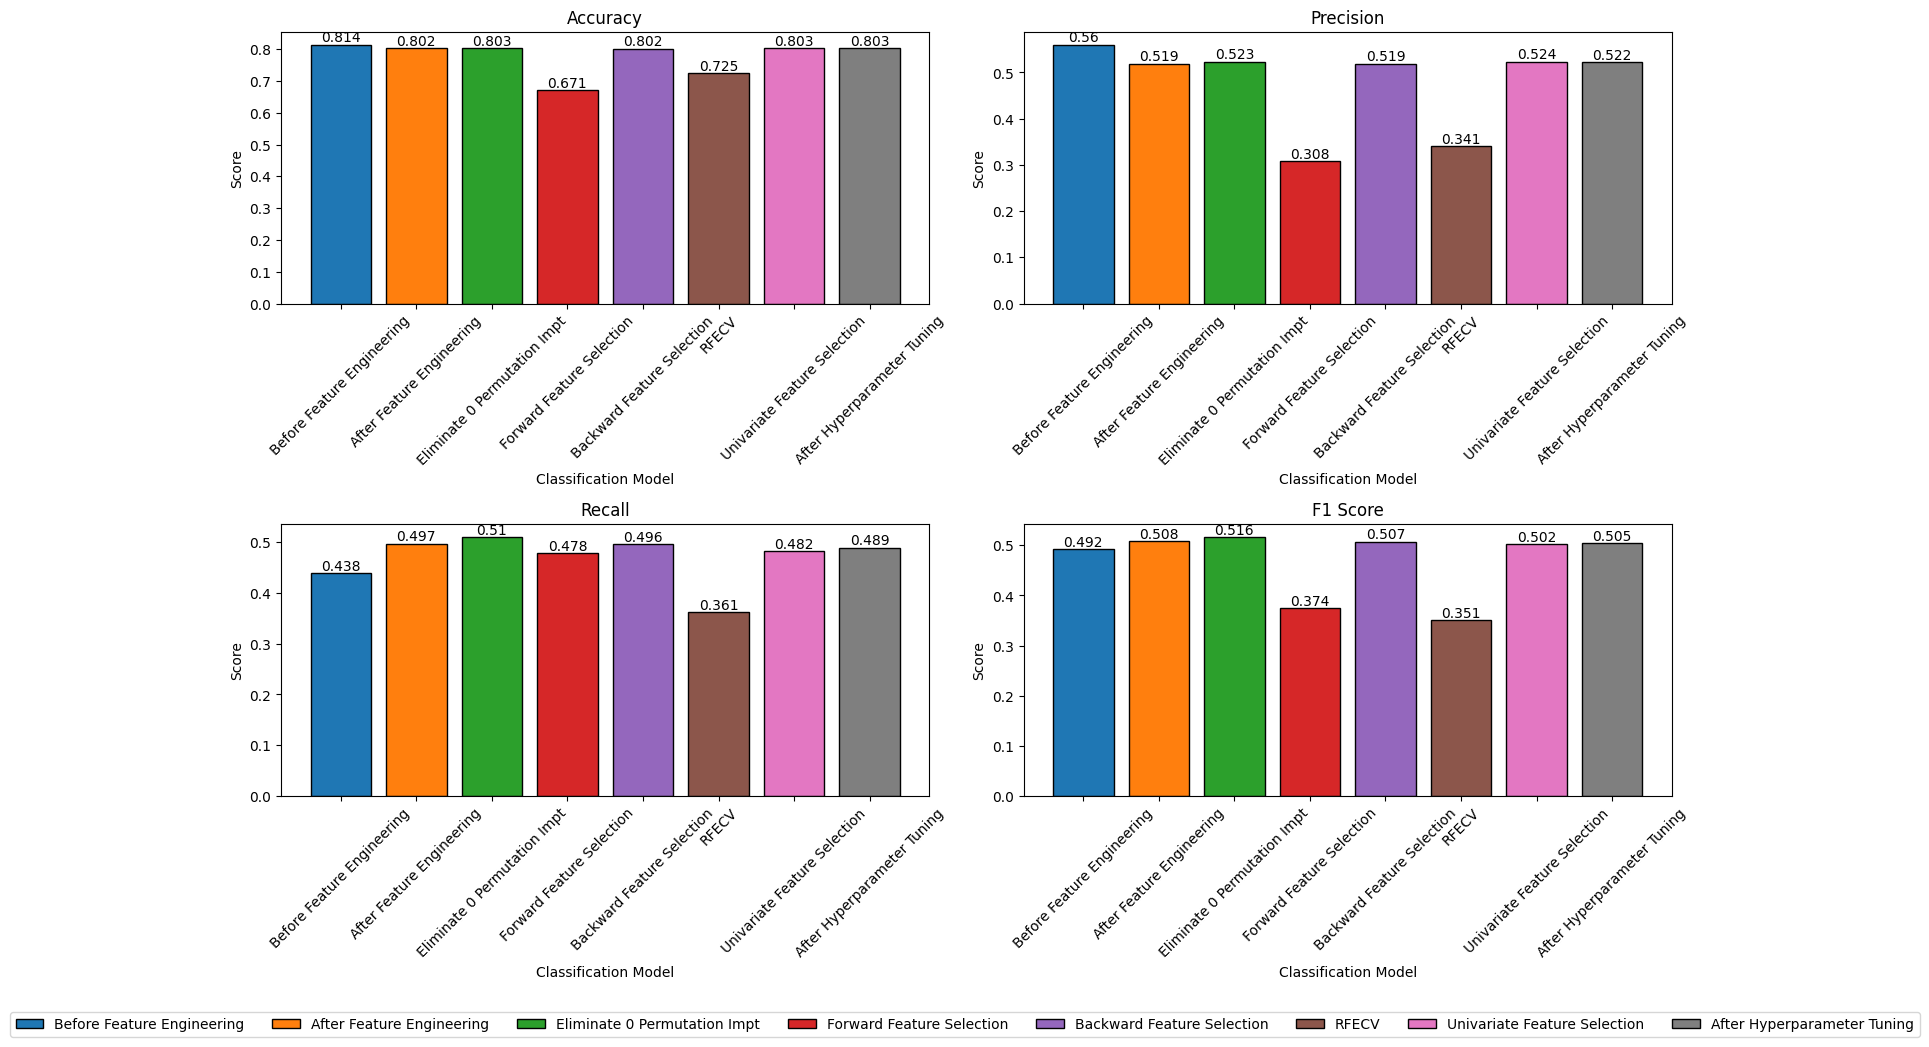

In [29]:
plotMetricsGraphComparison(test_metrics)

## Export Best Model

In [ ]:
# Exporting the features used for this model
from FeatureSelectionUtils import export_final_selected_features_to_csv

export_final_selected_features_to_csv(selected_features_backward, "Best Logistic Regression")

In [ ]:
# export the best model to be compared later on
import joblib

lr_final = LogisticRegression(max_iter=10000, C=0.1, penalty='l2', solver='liblinear', random_state = 47).fit(X_train[selected_features_backward], Y_train.values.ravel())

joblib.dump(lr_final, "FinalModels/BestLogisticRegression.pkl")

## Next Steps

Now, after doing feature selection and hyperparameter tuning, the model is exported out such that we can compare this classification model (logistic regression) with the best feature selection and hyperparameter tuning to other best classification models later.


## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb)
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb) 
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb) - <b>[You Are Here Now]</b>
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb)
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)